In [2]:
import csv
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras.layers import Dense, Embedding, LSTM

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split

In [3]:
import nltk
from nltk.corpus import stopwords 

nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /home/abner/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/abner/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
df = pd.read_csv("data_training.csv", sep=',',usecols=["topico", "texto"])

In [5]:
df_test = pd.read_csv("data_test.csv", sep=',',usecols=["topico", "texto"])

In [6]:
stop_words = stopwords.words('english')

df['texto'] = df['texto'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))

df_test['texto'] = df['texto'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop_words)]))



In [7]:
x_train, x_val, y_train, y_val = train_test_split(
    df['texto'], df['topico'],
    test_size=0.33,
    random_state=53) # https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html

In [8]:
x_test = df_test['texto']
y_test = df_test['topico']

In [9]:
EMBEDDING_DIMENSION = 300
VOCABULARY_SIZE = None # None mantem todas as palavras
NUM_EPOCHS = 10
OOV_TOK = '<OOV>'
TRUNCATE_TYPE = 'post'
PADDING_TYPE = 'post'

In [10]:
# Calcula a mediana do tamanho dos textos no conjunto e torna esse valor o tamanho máximo dos textos.
text_len = []
for i in list(x_train) + list(x_val):
    text_len.append(len(i))

MAX_LENGTH = np.median(text_len)
MAX_LENGTH = MAX_LENGTH.astype(np.int64)

In [11]:
#https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer

tokenizer = Tokenizer(num_words=VOCABULARY_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(list(x_train) + list(x_val))

In [12]:
tokenizer = Tokenizer(num_words=VOCABULARY_SIZE, oov_token=OOV_TOK)
tokenizer.fit_on_texts(list(x_test))

In [13]:
x_train_sequences = tokenizer.texts_to_sequences(x_train)
x_val_sequences = tokenizer.texts_to_sequences(x_val)
word_index = tokenizer.word_index
print('Vocabulary size:', len(word_index))


Vocabulary size: 20013


In [14]:
x_test_sequences = tokenizer.texts_to_sequences(x_test)

In [15]:
x_train_pad = pad_sequences(x_train_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)
x_val_pad = pad_sequences(x_val_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)


In [16]:
x_test_pad = pad_sequences(x_test_sequences, maxlen=MAX_LENGTH, padding=PADDING_TYPE, truncating=TRUNCATE_TYPE)

In [17]:
label_tokenizer = Tokenizer(filters='!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n')
label_tokenizer.fit_on_texts(list(y_train))

training_label_seq = np.array(label_tokenizer.texts_to_sequences(y_train))

In [18]:
label_tokenizer = Tokenizer(filters='!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n')
label_tokenizer.fit_on_texts(list(y_val))

val_label_seq = np.array(label_tokenizer.texts_to_sequences(y_val))

In [19]:
label_tokenizer = Tokenizer(filters='!"#$%&()*+,./:;<=>?@[\\]^_`{|}~\t\n')
label_tokenizer.fit_on_texts(list(y_test))

test_label_seq = np.array(label_tokenizer.texts_to_sequences(y_test))

In [20]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(len(word_index) + 1, EMBEDDING_DIMENSION),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(EMBEDDING_DIMENSION)),
    tf.keras.layers.Dense(EMBEDDING_DIMENSION, activation='relu'),
    tf.keras.layers.Dense(92, activation='softmax')
])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, None, 300)         6004200   
_________________________________________________________________
bidirectional (Bidirectional (None, 600)               1442400   
_________________________________________________________________
dense (Dense)                (None, 300)               180300    
_________________________________________________________________
dense_1 (Dense)              (None, 92)                27692     
Total params: 7,654,592
Trainable params: 7,654,592
Non-trainable params: 0
_________________________________________________________________


In [21]:
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy']) 
# https://keras.io/api/models/model_training_apis/ ; https://www.tensorflow.org/api_docs/python/tf/keras/metrics

In [22]:

history = model.fit(x_train_pad, training_label_seq, epochs=NUM_EPOCHS, validation_data=(x_val_pad, val_label_seq), verbose=2)

Train on 7646 samples, validate on 3767 samples
Epoch 1/10
7646/7646 - 1966s - loss: 1.9657 - accuracy: 0.5162 - val_loss: 1.6726 - val_accuracy: 0.6347
Epoch 2/10
7646/7646 - 2000s - loss: 1.2794 - accuracy: 0.6593 - val_loss: 1.8312 - val_accuracy: 0.6331
Epoch 3/10
7646/7646 - 1943s - loss: 0.9894 - accuracy: 0.7129 - val_loss: 2.0490 - val_accuracy: 0.6374
Epoch 4/10
7646/7646 - 1920s - loss: 0.8075 - accuracy: 0.7599 - val_loss: 2.1179 - val_accuracy: 0.6201
Epoch 5/10
7646/7646 - 1761s - loss: 0.6730 - accuracy: 0.7866 - val_loss: 2.5319 - val_accuracy: 0.6143
Epoch 6/10
7646/7646 - 1558s - loss: 0.5912 - accuracy: 0.8033 - val_loss: 2.5797 - val_accuracy: 0.6257
Epoch 7/10
7646/7646 - 1544s - loss: 0.5288 - accuracy: 0.8081 - val_loss: 2.8747 - val_accuracy: 0.6299
Epoch 8/10
7646/7646 - 1371s - loss: 0.4805 - accuracy: 0.8207 - val_loss: 2.8985 - val_accuracy: 0.6334
Epoch 9/10
7646/7646 - 1368s - loss: 0.4537 - accuracy: 0.8253 - val_loss: 3.0721 - val_accuracy: 0.6037
Epoch 1

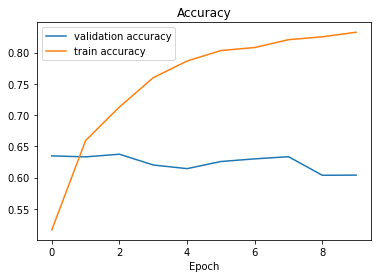

In [23]:
plt.title('Accuracy')
plt.plot(history.history['val_accuracy'], label='validation accuracy')
plt.plot(history.history['accuracy'], label='train accuracy')
plt.xlabel('Epoch')


plt.legend()
plt.show()

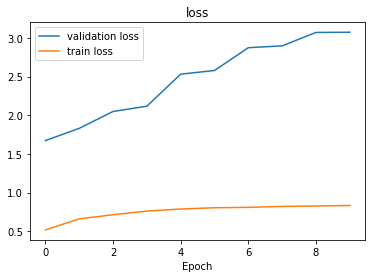

In [24]:
plt.title('loss')
plt.plot(history.history['val_loss'], label='validation loss')
plt.plot(history.history['accuracy'], label='train loss')
plt.xlabel('Epoch')


plt.legend()
plt.show()

In [25]:
test_eval = model.evaluate(x_test_pad, test_label_seq, verbose=2)

4024/1 - 172s - loss: 21.3823 - accuracy: 0.0539


In [26]:
y_pred = model.predict(x_test_pad)
y_pred_bool = np.argmax(y_pred, axis=1)

report = classification_report(test_label_seq, y_pred_bool) #https://scikit-learn.org/stable/modules/model_evaluation.html

print(report)



              precision    recall  f1-score   support

           1       0.38      0.01      0.02      1087
           2       0.01      0.01      0.01       719
           3       0.12      0.68      0.20       280
           4       0.01      0.02      0.01       189
           5       0.00      0.00      0.00       179
           6       0.08      0.01      0.01       149
           7       0.10      0.04      0.06       131
           8       0.00      0.00      0.00       117
           9       0.00      0.00      0.00        89
          10       0.00      0.00      0.00        71
          11       0.00      0.00      0.00        56
          12       0.17      0.02      0.04        47
          13       0.00      0.00      0.00        44
          14       0.00      0.00      0.00        37
          15       0.00      0.00      0.00        36
          16       0.00      0.00      0.00        35
          17       0.00      0.00      0.00        34
          18       0.00    

/home/abner/miniconda3/envs/outro_um/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abner/miniconda3/envs/outro_um/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/abner/miniconda3/envs/outro_um/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, le

In [ ]:
# Cria um CSV apartir do do report

report_t = classification_report(test_label_seq, y_pred_bool, output_dict=True)

df_report = pd.DataFrame(report_t).transpose()

df_report.to_csv('report.csv')



In [27]:
# Print f1, precision, and recall scores
precision = precision_score(test_label_seq, y_pred_bool , average="macro")
recall = recall_score(test_label_seq, y_pred_bool , average="macro")
f1 = f1_score(test_label_seq, y_pred_bool , average="macro")
accuracy = accuracy_score(test_label_seq, y_pred_bool )

print(precision)
print(recall)
print(f1)
print(accuracy)

0.009370510265615813
0.00853201584469779
0.003785029493228207
0.05392644135188867


/home/abner/miniconda3/envs/outro_um/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1248: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
